# Test different compression configuration for `xarrayvideo`

Notebook setup

In [1]:
#Autoreload .py files
%load_ext autoreload
%autoreload 2

#https://github.com/chmp/ipytest/issues/80
import sys
sys.breakpointhook = sys.__breakpointhook__

Load required libraries

In [2]:
import xarray as xr
import numpy as np
from pathlib import Path
from xarrayvideo import xarray2video, video2xarray, gap_fill, plot_image, to_netcdf
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings, shutil
import pandas as pd
import pickle
rng= np.random.default_rng(seed=42)

/home/oscar/.conda/envs/xv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set the configuration for the tests

In [ ]:
#Global config
DEBUG= False #If true, only one cube per test is performed, and errors are risen
DATASET= 'dynamicearthnet' #One of ['deepextremes', 'cesar', 'era5']
RULES_NAME= '4channels' #'11channels', '7channels', etc., just for save name

if DATASET == 'deepextremes':
    #Take N random cubes
    dataset_in_path= Path('/scratch/users/databases/deepextremes/deepextremes-minicubes/full')
    cube_paths= np.array(list(dataset_in_path.glob('*/*.zarr'))) #'*/*.zarr'
    rng.shuffle(cube_paths)
    cube_paths= cube_paths[:12]
if DATASET == 'dynamicearthnet':
    #Take N random cubes
    dataset_in_path= Path('/scratch/users/databases/dynamicearthnet-xarray')
    cube_paths= np.array(list(dataset_in_path.glob('*.nc')))
    rng.shuffle(cube_paths)
    cube_paths= cube_paths[:5]
elif DATASET == 'cesar':
    cube_paths= [Path('../s2data.npy')]
elif DATASET == 'era5':
    cube_paths= [Path(
    '../since_2022-07-01_2022-07-01_1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr')]    
else:
    raise RuntimeError(f'Unknown {DATASET=}')
    
#Define all tests
tests= ['libx265', 'vp9', 'JP2OpenJPEG']
# tests= ['libx265', 'libx265 (PCA)', 'libx265 (PCA - 9 bands)', 'JP2OpenJPEG']
# tests= ['libx265', 'libx265 (PCA)', 'libx265 (PCA - 12 bands)', 'JP2OpenJPEG'] #'libx265',   'libx265 (PCA)'
crfs= ['Best','Very high','High','Medium','Low','Very low']# + ['Very low 2', 'Very low 3'] 

#x265 config
x265_crfs_list= [51, #51, 51, 
                 51, 
                 1, 7, 16, 27, 
                 39, 39, 39, 39, 39, 39]
x265_param_list= [ 'lossless=1', 
                   # 'qpmin=0:qpmax=0.0000001:psy-rd=0:psy-rdoq=0', 
                   'qpmin=0:qpmax=0.01', 
                   # 'qpmin=0:qpmax=0.1:psy-rd=0:psy-rdoq=0'
                 ] + ['']*10
x265_params= [{'c:v': 'libx265', 'preset':'medium', 'tune':'psnr', 'crf': x265_crfs_list[i], 'x265-params':x265_param_list[i]} 
                for i in range(6)] #'tune:psnr' vs psy-rd=0:psy-rdoq=0
x265_params_PCA= [ {'c:v': 'libx265', 'preset':'medium', 
                    'crf': [x265_crfs_list[i]] + [x265_crfs_list[i+j] for j in range(5)], 
                    'x265-params': [x265_param_list[i]] + [x265_param_list[i+j] for j in range(5)] } 
                   for i in range(6)]
#VP9 config
# vp9_crfs_list= [0, 0, 0, 1, 5, 10, 20, 30]
# vp9_qmax_list= [0.0001, 0.01, 1, 10000, 10000, 10000]
vp9_params= [
    {'c:v': 'vp9', 'crf': 0, 'lossless': 1},
    # {'c:v': 'vp9', 'crf': 0, 'arnr-strength': 2, 'qmin': 0, 'qmax': 0.0001, 
    #  'lag-in-frames': 25, 'arnr-maxframes': 7},#Same results as with 'qmax': 0.01
    {'c:v': 'vp9', 'crf': 0, 'arnr-strength': 2, 'qmin': 0, 'qmax': 0.01, 
     'lag-in-frames': 25, 'arnr-maxframes': 7}, #Same results as with 'qmax': 0.01
    # {'c:v': 'vp9', 'crf': 1, 'arnr-strength': 2, 'qmin': 0, 'qmax': 1, 
    #  'lag-in-frames': 25, 'arnr-maxframes': 7}, #Same results as with 'qmax': 0.01
    {'c:v': 'vp9', 'crf': 5, 'arnr-strength': 2, 'lag-in-frames': 25, 'arnr-maxframes': 7},
    {'c:v': 'vp9', 'crf': 12, 'arnr-strength': 2, 'lag-in-frames': 25, 'arnr-maxframes': 7},
    {'c:v': 'vp9', 'crf': 20, 'arnr-strength': 2, 'lag-in-frames': 25, 'arnr-maxframes': 7},
    {'c:v': 'vp9', 'crf': 30, 'arnr-strength': 2, 'lag-in-frames': 25, 'arnr-maxframes': 7},
  ]

#JPEG200 params
jpeg2000_quality_list= [100, 80, 35, 15, 5, 1] #[100, 100, 75, 35, 15, 5, 3, 1]
jpeg2000_params= [ {'codec': 'JP2OpenJPEG', 'QUALITY': str(jpeg2000_quality_list[i]), 
                    'REVERSIBLE': 'YES' if i==0 else 'NO', 'YCBCR420':'NO'} for i in range(6)]

codec_params= dict(zip(tests, [x265_params, vp9_params, jpeg2000_params]))
# codec_params= dict(zip(tests, [x265_params, x265_params_PCA, x265_params_PCA, jpeg2000_params]))
n_bits= [12,16] #[12, 16]

Run the tests

In [ ]:
overall_results={}
for i, input_path in enumerate(pbar:=tqdm(cube_paths, total=len(cube_paths))):
    # For debugging
    if DEBUG and i > 0: break
    
    #Load data
    if DATASET == 'deepextremes':
        array_id= '_'.join(input_path.stem.split('_')[1:3])
        minicube= xr.open_dataset(input_path, engine='zarr')
        minicube['SCL']= minicube['SCL'].astype(np.uint8) #Fixes problem with the dataset
        minicube['cloudmask_en']= minicube['cloudmask_en'].astype(np.uint8)
        # minicube= minicube.drop_vars('B07') #We drop a variable for now

        #Align
        #TODO: Alignment is not working properly as of now
    
    elif DATASET == 'dynamicearthnet':
        minicube= xr.open_dataset(input_path)
        array_id= input_path.stem
        
    elif DATASET == 'cesar':
        data= np.load(input_path)
        cesar_bands= ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
        minicube= xr.Dataset(
            {band: ( ['time', 'x', 'y'], data[:,bi] ) for bi,band in enumerate(cesar_bands)},
            coords={
                'time': pd.date_range("2015-09-01", periods=106, freq='ME'),
                'x': np.arange(512),
                'y': np.arange(512),
            },
        )
        minicube= minicube.astype(np.float32) / 10000.
        array_id= 'cesar_0'
    elif DATASET == 'era5':
        era5= xr.open_dataset(input_path, engine='zarr')
        minicube= era5.sel(time=slice(pd.Timestamp('2022-11-01'), None)) #Choose small time subset
        array_id= 'ERA5_0'
        print(f'Size: {era5.nbytes / 2**30:.3f}Gb')
    else:
        raise RuntimeError(f'Unknown {DATASET=}')
        
    #Save cube id
    if array_id not in overall_results.keys(): overall_results[array_id]= {}

    #Run tests
    for test, codec_param in codec_params.items():
        if test not in overall_results[array_id].keys(): overall_results[array_id][test]= {}
        for crf, param in zip(crfs, codec_param, strict=False):
            if crf not in overall_results[array_id][test].keys(): overall_results[array_id][test][crf]= {}
            for bits in n_bits:
                #Update pbar
                pbar.set_description(f'{test=} | {array_id=} | {crf=} | {bits=}')

                #Skip bits that are not possible for a given codec
                if test != 'JP2OpenJPEG':
                    if bits not in [8,10,12]: continue
                else:
                    if bits not in [8,16]: continue
                
                if DATASET == 'deepextremes':
                    conversion_rules= {
                        # '7 bands': ( bands, ('time','x','y'), 
                        #             len(bands) if 'PCA' in test else False, param, bits),
                        'rgb': ( ('B04','B03','B02'), ('time','x','y'), False, param, bits),
                        # 'ir3': ( ('B8A','B06','B05'), ('time','x','y'), False, param, bits),
                        }
                elif DATASET == 'dynamicearthnet':
                    conversion_rules= {
                        'bands': (['R', 'G', 'B', 'NIR'], ('time', 'y', 'x'), False, param, bits),
                        }
                elif DATASET == 'cesar':
                    conversion_rules= {
                        # 'rgb': (['B4', 'B3', 'B2'], ('time', 'x', 'y'), False, param, bits),
                        'all': (cesar_bands, ('time', 'x', 'y'), 
                                9 if 'PCA' in test else False, param, bits),
                        }
                elif DATASET == 'era5':
                    conversion_rules= {
                    # 'wind': ( ('10m_u_component_of_wind', '10m_v_component_of_wind', '10m_wind_speed'), 
                    #           ('time', 'longitude', 'latitude'), False, param, bits),
                    # 'relative_humidity': ('relative_humidity', 
                    #                 ('time', 'longitude', 'latitude', 'level'), False, param, bits),
                    # 'wind_speed': ('wind_speed', 
                    #               ('time', 'longitude', 'latitude', 'level'), False, param, bits),
                    'temp': ('temperature', ('time', 'longitude', 'latitude', 'level'), 
                       13 if '(PCA)' in test else 12 if '(PCA - 12 bands)' in test else False, param, bits),
                    # 'wind_u': ('u_component_of_wind', ('time', 'longitude', 'latitude', 'level'), 
                    #    13 if '(PCA)' in test else 12 if '(PCA - 12 bands)' in test else False, param, bits),
                        }
                else:
                    raise RuntimeError(f'Unknown {DATASET=}')
        
                #Run with compute_stats
                try:
                    results= xarray2video(minicube, array_id, conversion_rules,
                                           output_path=Path('./testing/'), compute_stats=True,
                                           loglevel='verbose' if DEBUG else 'quiet',
                                           verbose=False, save_dataset=False,
                                           )
                    overall_results[array_id][test][crf][bits]= results
                    
                    #Delete the output folder
                    del_path= results[next(iter(conversion_rules.keys()))]['path'][0].parent
                    shutil.rmtree(del_path)

                except Exception as e:
                    print(f'{test=} | {array_id=} | {crf=} | {bits=}: Exception: {e}')
                    if DEBUG: raise e
                    #overall_results[array_id][test][crf][bits]= None
        
        #For some longer tests, just make sure that we don't lose everything...
        pickle.dump(overall_results, open('results_temp.pkl', 'wb'))

Process the results into a pandas dataframe

In [242]:
import pandas as pd
import seaborn as sns

#Reset matplotlib config and change defaults
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt, matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)    
plt.style.use('ggplot')
mpl.rcParams.update({'font.size': 10})

#We will create a dict only with metric values and convert it to pandas with multiindex
results_metrics={}
metrics_keep= ['compression', 'psnr', 'mse', 'bpppb', 'exp_sa', 'time', 'd_time', 'ssim']
for cube, cube_results in overall_results.items():
    #if cube not in ['_'.join(p.stem.split('_')[1:3]) for p in cube_paths]: continue
    for test, test_results in cube_results.items():
        for crf, crf_results in test_results.items():
            for bits, bits_results in crf_results.items():
                for video_name, metadata in bits_results.items():
                    if isinstance(metadata, dict): #Ignore 'path'
                        for metric in metrics_keep:
                            #if crf in ['Very low 3']: continue
                            try:
                                results_metrics[(metric, video_name, test, bits, cube, crf)]= metadata[metric]
                            except Exception as e:
                                print('Exception:', metadata['path'][0], e)
                                if 'acc' in metadata.keys() :
                                    print(f'{metadata["acc"]=}')
                                    if metadata['acc']>0.99999:
                                        print('Assigning best possible value!')
                                        results_metrics[(metric, video_name, test, bits, cube, crf)]= \
                                            {'psnr':100, 'mse':0, 'exp_sa':0, 'ssim':1.}[metric]
results_df = pd.DataFrame.from_dict(results_metrics, orient='index', columns=['value'])
results_df.index = pd.MultiIndex.from_tuples(results_df.index)
results_df.index.names = ['metric', 'video_name', 'test_name', 'bits', 'cube', 'crf']
save_name= f'./results/results_{DATASET}_{RULES_NAME}'
results_df.to_pickle(f'{save_name}.pkl')

Exception: testing/2850_4139_13/bands_{id}.jp2 'psnr'
metadata["acc"]=1.0
Assigning best possible value!
Exception: testing/2850_4139_13/bands_{id}.jp2 'mse'
metadata["acc"]=1.0
Assigning best possible value!
Exception: testing/2850_4139_13/bands_{id}.jp2 'exp_sa'
metadata["acc"]=1.0
Assigning best possible value!
Exception: testing/2850_4139_13/bands_{id}.jp2 'ssim'
metadata["acc"]=1.0
Assigning best possible value!
Exception: testing/2470_5030_13/bands_{id}.jp2 'psnr'
metadata["acc"]=0.9999999823635571
Assigning best possible value!
Exception: testing/2470_5030_13/bands_{id}.jp2 'mse'
metadata["acc"]=0.9999999823635571
Assigning best possible value!
Exception: testing/2470_5030_13/bands_{id}.jp2 'exp_sa'
metadata["acc"]=0.9999999823635571
Assigning best possible value!
Exception: testing/2470_5030_13/bands_{id}.jp2 'ssim'
metadata["acc"]=0.9999999823635571
Assigning best possible value!
Exception: testing/2832_4366_13/bands_{id}.jp2 'psnr'
metadata["acc"]=1.0
Assigning best possible 

Plot the results

Error processing test='libx265', video='bands', metric='psnr', bits=16: 16
Error processing test='vp9', video='bands', metric='psnr', bits=16: 16
Error processing test='JP2OpenJPEG', video='bands', metric='psnr', bits=12: 12
Error processing test='libx265', video='bands', metric='ssim', bits=16: 16
Error processing test='vp9', video='bands', metric='ssim', bits=16: 16
Error processing test='JP2OpenJPEG', video='bands', metric='ssim', bits=12: 12
Error processing test='libx265', video='bands', metric='exp_sa', bits=16: 16
Error processing test='vp9', video='bands', metric='exp_sa', bits=16: 16
Error processing test='JP2OpenJPEG', video='bands', metric='exp_sa', bits=12: 12
Error processing test='libx265', video='bands', metric='time', bits=16: 16
Error processing test='vp9', video='bands', metric='time', bits=16: 16
Error processing test='JP2OpenJPEG', video='bands', metric='time', bits=12: 12
Error processing test='libx265', video='bands', metric='d_time', bits=16: 16
Error processing 

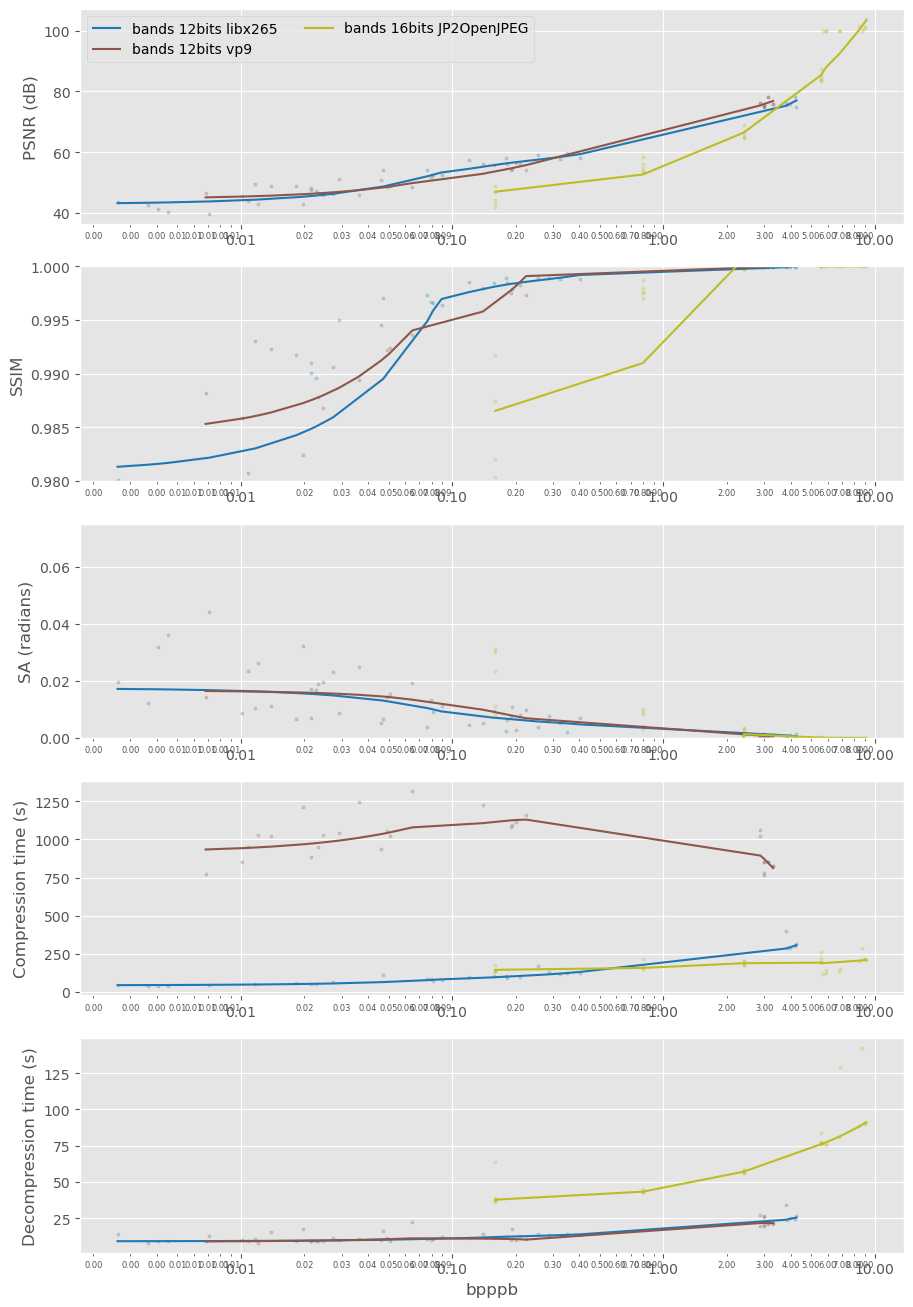

In [244]:
#Now plot it! 
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm

#Colors?
# cmap= plt.get_cmap('gist_rainbow')
# colors= [cmap(value) for value in np.linspace(0, 1, 15)] #0->1, 15 values
cmap= plt.get_cmap('tab10')
colors= [cmap(value) for value in [*np.linspace(0, 1, 8)]*2] #0->1, 12 values

#Load results?
save_name= f'results_{DATASET}_{RULES_NAME}'
# results_df= pd.read_pickle(f'{save_name}.pkl')

# x_label= 'Compression percentage' #One of {'Compression percentage', 'Compression factor', 'bpppb'}
x_label= 'bpppb'
c_index= 0 #Color index, go through the colormap
# tests_plot= ['libx265', 'libx265 (PCA)', 'libx265 (PCA - 12 bands)', 'JP2OpenJPEG']
tests_plot= ['libx265', 'vp9', 'JP2OpenJPEG']
metrics_plot= {'psnr':'PSNR (dB)', 
               #'mse':'MSE', #We disable MSE because it is very difficult to plot
               'ssim':'SSIM', 'exp_sa':'SA (radians)', 
               'time': 'Compression time (s)', 'd_time': 'Decompression time (s)'}
metrics_plot= {m:label for m, label in metrics_plot.items() if m in metrics_keep}
f, axes= plt.subplots(len(metrics_plot),1, figsize=(6.25*1.7,9.5*1.7))
for i, ((metric, y_label), ax) in enumerate(zip(metrics_plot.items(), axes.flatten())):
    ax.set_ylabel(y_label)
    c_index= 0
    
    if y_label == 'MSE':
        ax.set_yscale('log')
        # ax.yaxis.set_major_formatter(mtick.ScalarFormatter())
        # ax.yaxis.set_minor_formatter(mtick.ScalarFormatter())
        # ax.tick_params(axis='y', which='minor', labelsize=6) 
        ax.set_ylim(1e-7, 5e-3)  # Set y limits for MSE to avoid extreme values
    elif y_label == 'SSIM':
        ax.set_ylim(0.98, 1.0)  # Adjust SSIM y-limits for better separation
    elif y_label == 'SA (radians)':
        ax.set_ylim(0., 0.075)
        
    if x_label == 'Compression factor':
        #If using a factor for compression
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(mtick.ScalarFormatter())
        ax.xaxis.set_minor_formatter(mtick.ScalarFormatter())
        ax.tick_params(axis='x', which='minor', labelsize=6) 
    elif x_label == 'Compression percentage':
        #If using percentage for compression
        ax.xaxis.set_major_formatter(mtick.PercentFormatter())
        start, end = ax.get_xlim()
    elif x_label == 'bpppb':
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
        ax.xaxis.set_minor_formatter(mtick.FormatStrFormatter('%.2f'))
        ax.tick_params(axis='x', which='minor', labelsize=6) 
    else:
        raise AssertionError(f'Unknown {x_label=}')

    for i_video, video in enumerate(conversion_rules.keys()):
        for test in tests_plot:
            for bits in n_bits:
                try:
                    data= results_df.xs(test, level='test_name').xs(video, level='video_name').xs(bits, level='bits')
                    metric_values= data.xs(metric, level='metric').values.flatten()
                    if x_label == 'Compression factor':
                        compression_values= 1/data.xs('compression', level='metric').values.flatten()
                    elif x_label == 'Compression percentage':
                        compression_values= data.xs('compression', level='metric').values.flatten()
                    elif x_label == 'bpppb':
                        compression_values= data.xs('bpppb', level='metric').values.flatten()
                    else:
                        raise AssertionError(f'Unknown {x_label=}')
                    scatter_kws= {'s': 5, 'alpha': 0.25}
                    line_kws= {'linestyle': {8:':', 10:'--', 12:'-', 16:'-'}[bits], 'label':f'{video} {bits}bits {test}'}
                    compression_values_plot= compression_values * (100 if x_label == 'Compression percentage' else 1)
                    color= {'libx265':colors[0], 'vp9':colors[4], 'libx265 (PCA)':colors[4], 
                            'libx265 (PCA - 12 bands)': colors[2], 'JP2OpenJPEG':colors[6]}[test] #colors[c_index]
                    
                    #Ensure compression_values is sorted
                    sorted_indices= np.argsort(compression_values)#[-len(metric_values):]
                    compression_values_sorted= compression_values_plot[sorted_indices]
                    metric_values_sorted= metric_values[sorted_indices]
                    
                    #Lowess smoothing
                    metric_values_smoothed= sm.nonparametric.lowess(metric_values_sorted, compression_values_sorted, 
                                                                    frac=0.6, return_sorted=False)

                    #Scatter plot and lineplot in separate calls
                    ax.scatter(compression_values_sorted, metric_values_sorted, color=color, **scatter_kws)
                    ax.plot(compression_values_sorted, metric_values_smoothed, color=color, **line_kws)

                    # sns.regplot(x=comopression_values_plot, 
                    #             y=metric_values, ax=ax, 
                    #             # lowess=True, 
                    #             color=colors[c_index], 
                    #             scatter_kws=scatter_kws, line_kws=line_kws, 
                    #             marker=['o', '*', 'D', '^', '*'][i_video], #Overwrites scatter_kws
                    #            ) 
                    c_index+= 1
                except Exception as e:
                    print(f'Error processing {test=}, {video=}, {metric=}, {bits=}: {e}')
                    if 'index' in str(e): raise e

    # if metric not in ['time']: 
    #     ax.axhline(metric_values[0], color='darkred', linestyle='--', label='uint8 discretization limit')
    if i==0: ax.legend(ncol=2)
        
ax.set_xlabel(x_label)
plt.savefig(f'./examples/{save_name}_{x_label.lower().replace(" ","_")}.png', dpi=200, bbox_inches='tight')
plt.show()

In [235]:
# Analyze the results in tabular form
for metric in ['bpppb', 'psnr', 'time']:
    pd.set_option('display.max_rows', None)
    data= results_df.xs('libx265', level='test_name').xs('bands', level='video_name').xs(12, level='bits').xs(metric, level='metric')
    grouped= data.groupby(level='crf').mean()

    grouped.index = pd.Categorical(grouped.index, categories=crfs, ordered=True)
    print(grouped.sort_index())

              value
Best       4.022729
Very high  0.324014
High       0.169613
Medium     0.074598
Low        0.020328
Very low   0.004379
               value
Best       76.110373
Very high  58.630659
High       56.695280
Medium     53.035128
Low        47.869363
Very low   41.484409
                value
Best       317.544352
Very high  133.923382
High        99.438271
Medium      85.591230
Low         54.334228
Very low    42.909723
